In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from wordcloud import WordCloud
import re

"Libraries to help with jupyter notebook usage"
# Increases jupyter notebook display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# Helps display images in notebook
from IPython.display import Image

## Data Import
Import files containing information regarding tracks from over 10,000 playlists in terms of audio featuers and various details such as global popularity and release date

In [2]:
audio_features_df = []
track_details_df = []

for i in range(10):
    audio_features_file_path = f'../data/processed_data/audio_features/audio_features-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(audio_features_file_path)
    audio_features_df.append(df)
    
    track_details_file_path = f'../data/processed_data/playlist_details/details-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(track_details_file_path)
    track_details_df.append(df)

audio_features_df = pd.concat(audio_features_df, ignore_index=True)
track_details_df = pd.concat(track_details_df, ignore_index=True)

original_track_details_df = track_details_df.copy()
original_audio_features_df = audio_features_df.copy()

## 2. Data Pre-processing
1. Remove irrelevant columns such as key and duration
2. Remove outliers for each audio features in `audio_features_df`
3. Perform One-Hot-Encoding (OHE) for `track_popularity` and `release_date` in `track_details_df`
    - OHE for `track_popularity` done by grouping them into buckets of their nearest 10s
    - OHE for `release_date` done by grouping them into the year released 
4. Combining `audio_features_df` and `track_details_df`

In [3]:
# Dropping irrelevant columns

audio_features_df = original_audio_features_df.drop(columns=['key', 'duration_ms', 'instrumentalness'])

### 2.1 Removing outliers from audio features
Despite the official Spotify API Documentation mentioning that most audio features are within the range of 0 to 1, a simple `track_details_df.describe()` shows its definitely not the case. To better visualize each audio feature's distribution, let's plot them out:

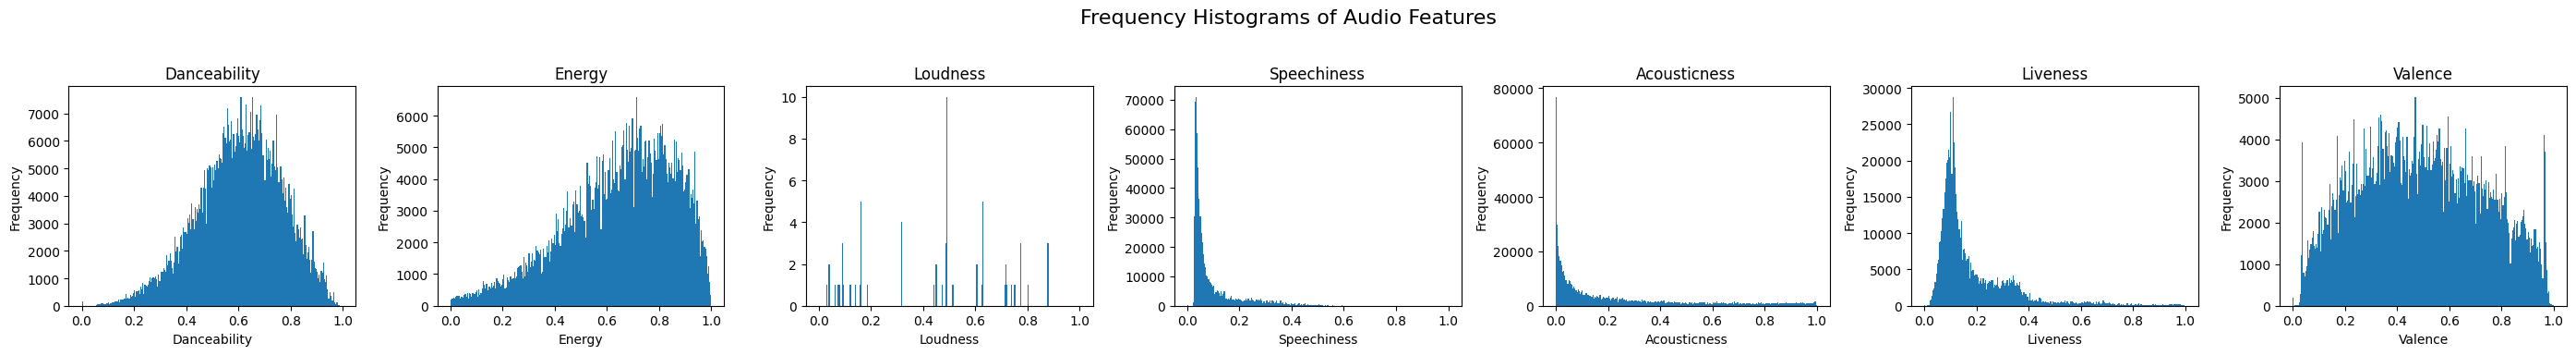

In [151]:
graph_audio_features_df = original_audio_features_df.copy()

num_bins = 250

audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence']

graph_height = 4
graph_width = 4
graph_count = len(audio_features_list)

fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
fig.suptitle('Frequency Histograms of Audio Features', fontsize=16)

for i, audio_feature in enumerate(audio_features_list):
    ax = axes[i]
    ax.hist(graph_audio_features_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
    ax.set_title(f'{str(audio_feature).capitalize()}')
    ax.set_xlabel(f'{audio_feature.capitalize()}')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

It's immediately noticeable that only audio features `Danceability`, `Energy`, and `Valence` are "normal" (excuse the pun). The distribution of `Loudness` is also noticeably messy due to its range of [-60, 0], let's fix that using min-max normalization. 

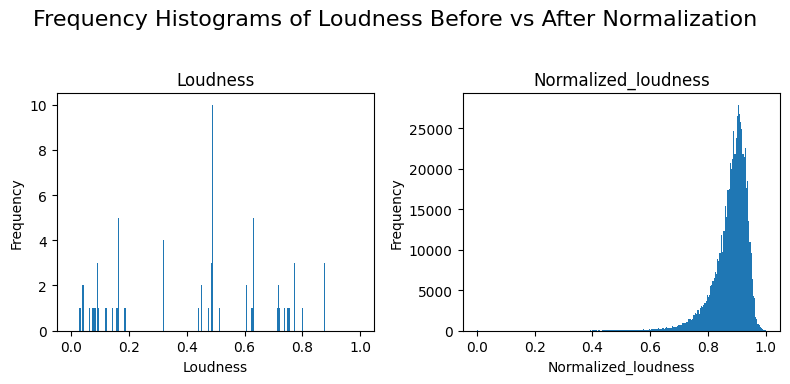

In [152]:
max_loudness = 0
min_loudness = -60
graph_audio_features_df['normalized_loudness'] = (graph_audio_features_df['loudness'] - min_loudness) / (max_loudness - min_loudness)

audio_features_list = ['loudness', 'normalized_loudness']

graph_count = len(audio_features_list)

fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
fig.suptitle('Frequency Histograms of Loudness Before vs After Normalization', fontsize=16)

for i, audio_feature in enumerate(audio_features_list):
    ax = axes[i]

    ax.hist(graph_audio_features_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
    ax.set_title(f'{str(audio_feature).capitalize()}')
    ax.set_xlabel(f'{audio_feature.capitalize()}')
    ax.set_ylabel('Frequency')

graph_audio_features_df['loudness'] = graph_audio_features_df['normalized_loudness']
graph_audio_features_df = graph_audio_features_df.drop(columns=['normalized_loudness'])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Looks so much better. Now that we know `Loudness` is heavily left-skewed, while `Speechiness`, `Acousticness` and `Liveness` are heavily right-skewed, we can perform square-transformation and square-root-transformation to them respectively.

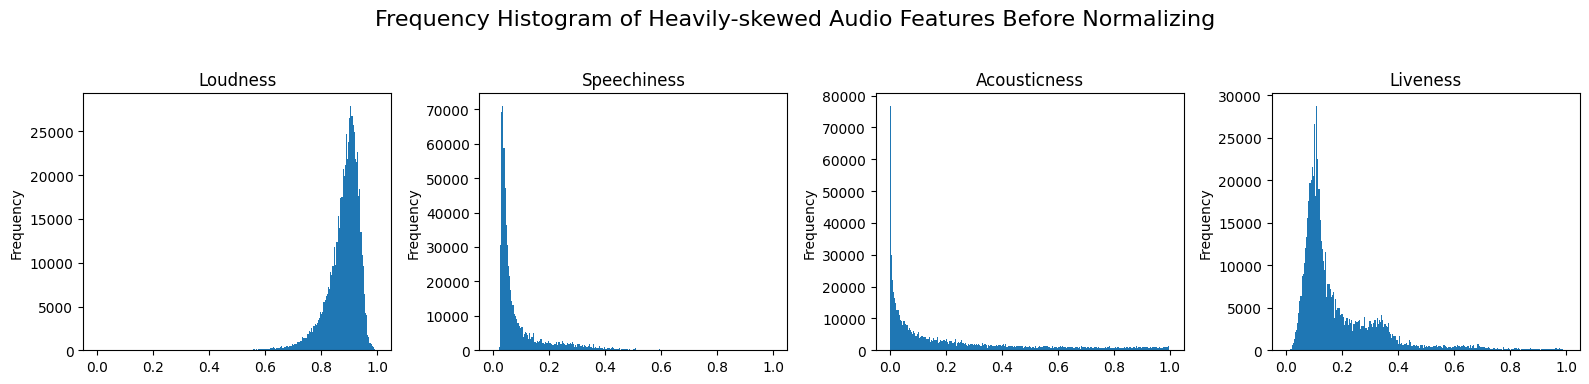

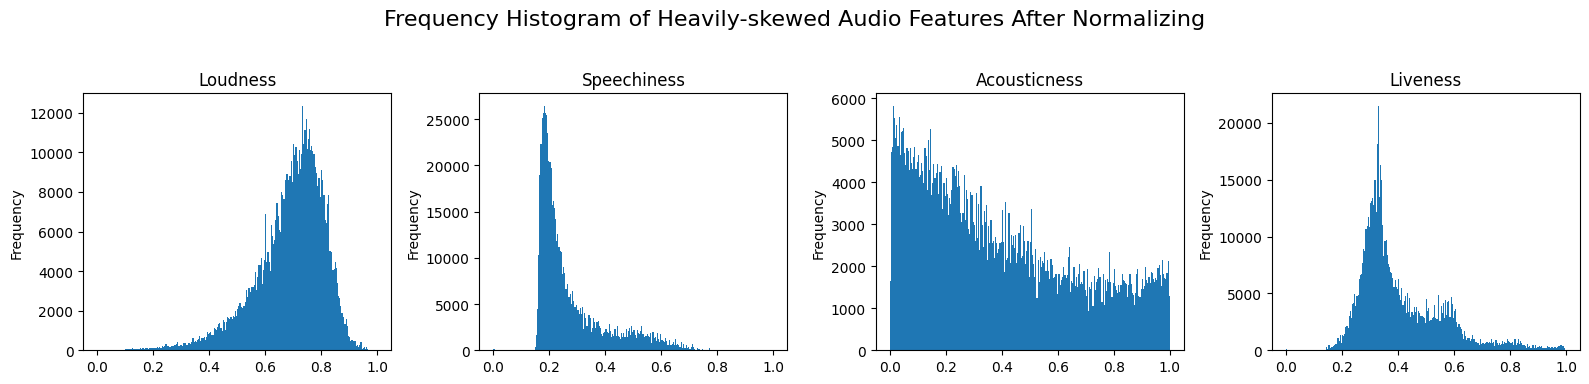

In [155]:
audio_features_list = ['loudness','speechiness', 'acousticness', 'liveness']

new_graph_audio_features_df = graph_audio_features_df.copy()
new_graph_audio_features_df['loudness'] = graph_audio_features_df['loudness'].apply(lambda x : x**3)

def normalize_using_iqr(x):
    median = x.median()
    iqr = x.quantile(0.75) - x.quantile(0.25)
    return (x - median) / iqr

non_zero_columns = ['speechiness', 'acousticness', 'liveness']
for column in non_zero_columns:
    new_graph_audio_features_df[column] = graph_audio_features_df[column].apply(lambda x : np.sqrt(x))


graph_count = len(audio_features_list)

fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
fig.suptitle('Frequency Histogram of Heavily-skewed Audio Features Before Normalizing', fontsize=16)

for i, audio_feature in enumerate(audio_features_list):
    ax = axes[i]

    ax.hist(graph_audio_features_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
    ax.set_title(f'{str(audio_feature).capitalize()}')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
fig.suptitle('Frequency Histogram of Heavily-skewed Audio Features After Normalizing', fontsize=16)

for i, audio_feature in enumerate(audio_features_list):
    ax = axes[i]

    ax.hist(new_graph_audio_features_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
    ax.set_title(f'{str(audio_feature).capitalize()}')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Although several audio features are yet to be close to normal, it is still way better than where we started from. Here's the final frequency histograms for every audio feature after various normalization techniques have been applied

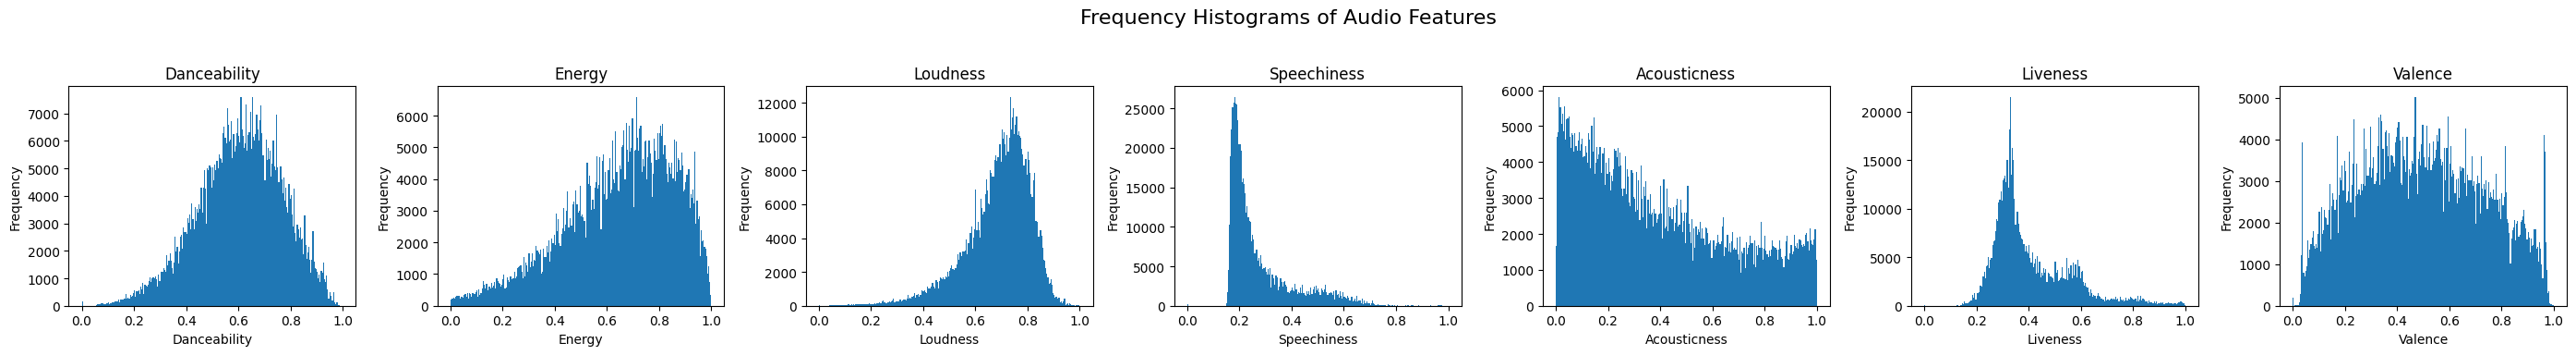

In [160]:
audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence']
graph_count = len(audio_features_list)

fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
fig.suptitle('Frequency Histograms of Audio Features', fontsize=16)

for i, audio_feature in enumerate(audio_features_list):
    ax = axes[i]
    ax.hist(new_graph_audio_features_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
    ax.set_title(f'{str(audio_feature).capitalize()}')
    ax.set_xlabel(f'{audio_feature.capitalize()}')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

audio_features_df = new_graph_audio_features_df

In [ ]:
lower_quantile = 0.20
upper_quantile = 0.80
# removes 'id' column
audio_features = audio_features_df.columns[1:]
quantiles = audio_features_df[audio_features].quantile([lower_quantile, upper_quantile])

for feature in audio_features:
    lower_threshold = quantiles.loc[lower_quantile, feature]
    upper_threshold = quantiles.loc[upper_quantile, feature]
    
    audio_features_df = original_audio_features_df[(original_audio_features_df[feature] >= lower_threshold) & (original_audio_features_df[feature] <= upper_threshold)]

In [ ]:
track_details_df['release_date'] = original_track_details_df['release_date'].apply(lambda date_str: date_str.split('-')[0] if isinstance(date_str, str) and '-' in date_str else date_str)

track_details_df['track_popularity'] = original_track_details_df['track_popularity'].apply(lambda popularity: (int(popularity // 10) * 10) if not pd.isna(popularity) else popularity)

Due to some issues with spotify's song database, the audio_features for all songs still remain in the DB (presumably for analysis purpose), but the track details (allbum, date of release, artist) have been removed. 

This caused quite a headache and took quite a long time to realize the issue, but alast it has been fixed, the rows with such missing data has been labelled as NA during the data retrieval process, for simple data pre-processing.

The `merged_df` now contains information from `audio_features_df` as well as `track_details_df`, joined on the track id

In [ ]:
def read_and_combine_source(start_index, end_index):
    source_dfs = []
    for i in range(start_index, end_index + 1):
        source_file = f'../data/processed_data/audio_features/audio_features-{i*1000}-{(i+1)*1000 - 1}.csv'
        df = pd.read_csv(source_file)
        source_dfs.append(df)
    return pd.concat(source_dfs)

def read_and_combine_target(start_index, end_index):
    target_dfs = []
    for i in range(start_index, end_index + 1):
        target_file = f'../data/processed_data/playlist_details/details-{i*1000}-{(i+1)*1000 - 1}.csv'
        df = pd.read_csv(target_file)
        target_dfs.append(df)
    return pd.concat(target_dfs)

file_start_index = 0
file_end_index = 9
combined_source_df = pd.concat([read_and_combine_source(file_start_index, file_end_index)])
combined_target_df = pd.concat([read_and_combine_target(file_start_index, file_end_index)])

merged_df = combined_source_df.merge(combined_target_df, on='id', how='inner')

tracks_with_missing_details = merged_df.loc[merged_df['track_uri'].isna(), 'id']

merged_df = merged_df.drop(index=merged_df[merged_df['id'].isin(tracks_with_missing_details)].index)

# Data Visualization
## Scatter Plot 
Allows better visualization of how one audio feature tends to affect the rest

In [ ]:
audio_features = filtered_df.columns[1:]

num_rows = 1
num_cols = len(audio_features)

subplot_size = 5
fig_row_size = subplot_size * num_cols
fig_col_size = subplot_size

audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']

for af in audio_features_list:
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(fig_row_size, fig_col_size))
    
    for i, feature in enumerate(audio_features):
        axs[i].hexbin(x=filtered_df[af], y=filtered_df[feature], alpha=1, gridsize=25, cmap='terrain')
        
        axs[i].set_xlabel(af)
        axs[i].set_ylabel(feature)
        
        # Adding linear regression line
        slope, intercept = np.polyfit(filtered_df[af], filtered_df[feature], 1)
        x_values = [filtered_df[af].min(), filtered_df[af].max()]
        y_values = [slope * x + intercept for x in x_values]
        axs[i].plot(x_values, y_values, color='red', linewidth=2)
    
    plt.tight_layout()
    plt.savefig(f"../resources/audio_feature_plots/plot_{af}.png", format="png", dpi=30)
    plt.show()

## Correlation Matrix
Overview of the correlation between audio features (note: correlation need not necessarily imply causation)

In [ ]:
import numpy as np
import pandas as pd

# Assuming you have already calculated the correlation_matrix
correlation_matrix = filtered_df[audio_features_list].corr()

# Create a mask to hide the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the correlation matrix as a heatmap, showing only the values in the upper triangle
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0, mask=~mask)
plt.title("Correlation Matrix of Audio Features")
plt.savefig(f"../resources/audio_feature_plots/correlation.png", format="png", dpi=50)
plt.show()

## Genre Clustering
Clusters genres obtained from Spotify API using kmeans algorithm

In [ ]:
from constants import global_genres as definitions

# Convert the preprocessed definitions to TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(definitions)

# Use K-means clustering to group similar definitions
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)

cluster_labels = kmeans.labels_

# Concatenate definitions for each cluster without the cluster labels
clusters = {}
for i, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    # Remove the [Cluster X] [X] annotations from the definitions
    clean_definition = ' '.join([word for word in definitions[i].split() if not word.startswith('[')])
    # Remove all numbers from the clean_definition using regex
    clean_definition = re.sub(r'\d+', '', clean_definition).replace(']', '')
    clusters[label].append(clean_definition)

### Cluster Based Word Cloud
Clustering genres based on definitions

In [ ]:
# Generate word clouds for each cluster
for label, cluster_definitions in clusters.items():
    all_definitions = ' '.join(cluster_definitions)
    word_list = all_definitions.split()
    # covert to set to remove duplicates
    unique_words = list(set(word_list))  
    unique_definitions = ' '.join(unique_words)

    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(unique_definitions)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {label}')
    plt.savefig(f"../resources/wordclouds/cluster_{label}.png", format="png", dpi=50)
    plt.show()

### Overall Word Cloud
Word cloud based on frequency of words in each genre

In [ ]:
# Generate word clouds for each cluster and get word frequencies
word_frequencies = {}
for label, cluster_definitions in clusters.items():
    all_definitions = ' '.join(cluster_definitions)
    word_list = all_definitions.split()
    for word in word_list:
        if word in word_frequencies:
            word_frequencies[word] += 1
        else:
            word_frequencies[word] = 1

# Generate the large word cloud with overlapping clusters
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_frequencies)

# Display the large word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud')
plt.savefig(f"../resources/wordclouds/overall.png", format="png", dpi=50)
plt.show()